**https://humboldt-wi.github.io/blog/research/information_systems_1819/group5_han/**

In [0]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
from bs4 import BeautifulSoup
import re

import os
import sys
from IPython.display import display, HTML
import urllib
import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import pip
import theano
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras import initializers as initializers, regularizers, constraints
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Sequential, Model, load_model
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils import plot_model, np_utils
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Functions

In [0]:
def cleanString(review,stopWords):
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list

In [0]:
def split_df(dataframe, column_name, training_split = 0.6, validation_split = 0.2, test_split = 0.2):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each categorie as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6
             validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

In [0]:
def wordToSeq(text,word_index,max_sentences,max_words,max_features):
    """
    Converts a string to a numpy matrix where each word is tokenized.
    Arrays are zero-padded to max_sentences and max_words length.
    
    Input:    text           - string of sentences
              word_index     - trained word_index
              max_sentences  - maximum number of sentences allowed per document for HAN
              max_words      - maximum number of words in each sentence for HAN
              max_features   - maximum number of unique words to be tokenized
    Output:   data           - Numpy Matrix of size [max_sentences x max_words]
    """
    sentences = tokenize.sent_tokenize(text)
    data = np.zeros((max_sentences, max_words), dtype='int32')
    for j, sent in enumerate(sentences):
        if j< max_sentences:
            wordTokens = tokenize.word_tokenize(sent.rstrip('.'))
            wordTokens = [w for w in wordTokens]
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_words and word_index[word]<max_features:
                        data[j,k] = word_index[word]
                        k=k+1
                except:
                    pass
    return data

In [0]:
def to_categorical(series,class_dict):
    """
    Converts category labels to vectors,
    Input:     series     - pandas Series containing numbered category labels
               class_dict - dictionary of integer to category string 
                            e.g. {0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}
    Output:    Array      - numpy array containing categories converted to lists
                            e.g. 0:'business'      -> [1 0 0 0 0]
                                 1:'entertainment' -> [0 1 0 0 0]
                                 2:'politics'      -> [0 0 1 0 0]
                                 3:'sport'         -> [0 0 0 1 0]
                                 4:'tech'          -> [0 0 0 0 1]
    """
    n_classes = len(class_dict)
    new_dict = {}
    for key,value in class_dict.items():
        cat_list = [0] * n_classes
        cat_list[key] = 1
        new_dict[key] = cat_list
    y_cat = []
    for key,value in series.iteritems():
        y_cat.append(new_dict[value])
    return np.array(y_cat)

# Attention layer

In [0]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

# Load Data

In [0]:
data_df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/data_consolidated.xlsx")

In [0]:
data_df.head()

,Text,Category
0,Ad sales boost Time Warner profit. Quarterly p...,business
1,Court rejects $280bn tobacco case. A US govern...,business
2,Dollar gains on Greenspan speech. The dollar h...,business
3,Ask Jeeves tips online ad revival. Ask Jeeves ...,business
4,"India calls for fair trade rules. India, which...",business


In [0]:
# # Current working directory(directory which contains these jupyter notebook)
# """
# Reads the current working directory and searches for the directory 'bbc'.
# Every sub directory in directory 'bbc' is searched for .txt files.
# Every .txt file is read and saved. The sub directory name containt the .txt file is used the label.
# """
# filepath = os.path.join(os.getcwd(),"/content/drive/My Drive/Colab Notebooks/bbc 2")
# articles = []
# category_num = {}
# count = 0
# for item in os.listdir(filepath):
#     category_num[item] = count
#     count += 1
#     if os.path.isdir(os.path.join(filepath,item)):
#         sub_dir = os.path.join(filepath,item)
#         files = [f for f in os.listdir(sub_dir) 
#          if os.path.isfile(os.path.join(sub_dir,f))]
#         for file in files:
#             with open(os.path.join(sub_dir,file), encoding='utf-8', errors='ignore') as text:
#                 data = text.read()
#                 paragraphs = data.split('\n', -1)
#                 title = paragraphs[0] + '. '
#                 paragraphs[0] = title
#                 data = ''.join(paragraphs)
#                 articles.append((data,item))

# data_df = pd.DataFrame(data=articles,columns=['Text',"Category"])

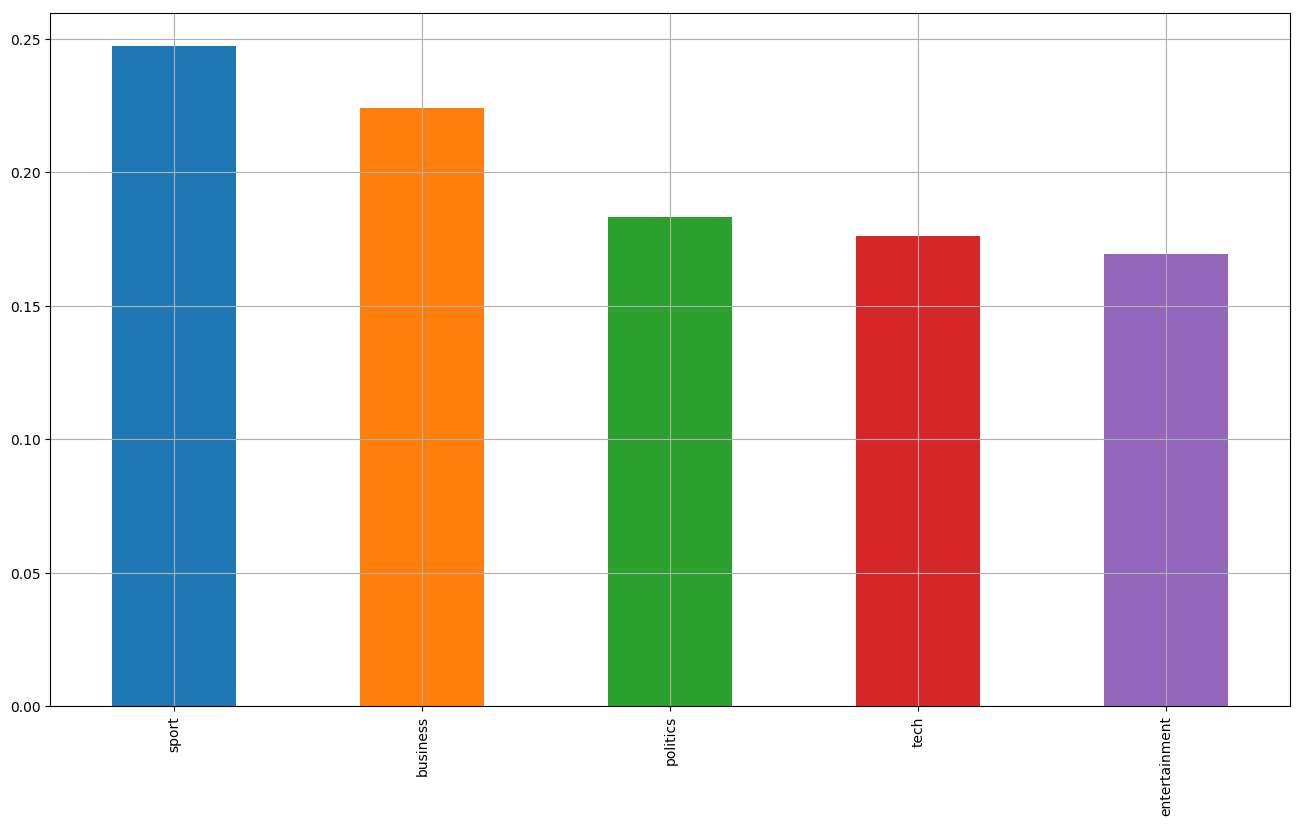

In [0]:
data_df.Category.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(16, 9))

In [0]:
# """
# Compute average number of words in each sentence and average number of sentences in each document.
# """
# n_sent = 0
# n_words = 0
# for i in range(data_df.shape[0]):
#     sent = tokenize.sent_tokenize(data_df.loc[i,'Text'])
#     for satz in sent:
#         n_words += len(tokenize.word_tokenize(satz))
#     n_sent += len(sent)
    
# print("Average number of words in each sentence: ",round(n_words/n_sent))
# print("Average number of sentences in each document: ", round(n_sent/data_df.shape[0]))

Average number of words in each sentence:  26
Average number of sentences in each document:  17


In [0]:
# data_df.to_excel("/content/drive/My Drive/Colab Notebooks/data_consolidated.xlsx", index=False)

# Parameters

In [0]:

MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 100      # vector size of word embedding

# Data Preprocessing

In [0]:
data_cleaned = pd.read_excel('/content/drive/My Drive/Colab Notebooks/data_cleaned.xlsx')

In [0]:
"""
Cleans raw data using the cleanString() function from above.
English stopwords are used from nltk library.
Cleaned dataset is saved in 'data_cleaned' pandas dataframe.
Labels are converted to numbers,
"""
articles = []
n = data_df['Text'].shape[0]
col_number = data_df.columns.get_loc('Text')
stopWords = set(stopwords.words('english'))
data_cleaned = data_df.copy()
for i in range(n):
    temp_string,idx_string = cleanString(data_df.iloc[i,col_number],stopWords)
    articles.append(temp_string)
    print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
data_cleaned.loc[:,'Text'] = pd.Series(articles,index=data_df.index)
data_cleaned.loc[:,'Category'] = pd.Categorical(data_cleaned.Category)
data_cleaned['Code'] = data_cleaned.Category.cat.codes
categoryToCode = dict( enumerate(data_cleaned['Category'].cat.categories))

data_cleaned.head()

NameError: ignored

In [0]:
# data_cleaned.to_excel("/content/drive/My Drive/Colab Notebooks/data_cleaned.xlsx", index=False)

# Tokenisation

In [0]:
"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
texts = []
n = data_cleaned['Text'].shape[0]
for i in range(n):
    s = data_cleaned['Text'].iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# GloVe Embedding Matrix

In [0]:
"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open(os.path.join(os.getcwd(), '/content/drive/My Drive/Colab Notebooks/glove.6B.100d.txt'),encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

# Search words in our word index in the pre-trained dataset
# Create an embedding matrix for our bbc dataset
min_wordCount = 0
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')

Found 400000 word vectors.
Total absent words are 1409 which is 5.57 % of total words
Words with 0 or less mentions 0 which is 0.00 % of total words


# Splitting Dataset

In [0]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""

print(categoryToCode)
train, validation, test = split_df(data_cleaned, 'Code',0.8,0.1,0.1)

#Training
paras = []
for i in range(train['Text'].shape[0]):
    sequence = wordToSeq(train['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_train = np.array(paras)
y_train = to_categorical(train['Code'],categoryToCode)

#Validation
paras = []
for i in range(validation['Text'].shape[0]):
    sequence = wordToSeq(validation['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_val = np.array(paras)
y_val = to_categorical(validation['Code'],categoryToCode)

#Test
paras = []
for i in range(test['Text'].shape[0]):
    sequence = wordToSeq(test['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_test = np.array(paras)
y_test = to_categorical(test['Code'],categoryToCode)

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}
Total:  2277
Training:  1822 , Percentage:  0.8001756697408872
Validation:  227 , Percentage:  0.09969257795344752
Test: 228 , Percentage:  0.10013175230566534


# HAN Model

In [0]:
"""
Create Keras functional model for hierarchical attention network
"""
embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
                            input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(5, activation='softmax',name='output')(sent_drop)

# Model compile
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())

plot_model(model, to_file='model.png',show_shapes=True)
plot_model(wordEncoder, to_file='wordEncoder.png',show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      (None, 50)                0         
_________________________________________________________________
word_embedding (Embedding)   (None, 50, 100)           2531300   
_________________________________________________________________
word_gru (Bidirectional)     (None, 50, 100)           45300     
_________________________________________________________________
word_dense (Dense)           (None, 50, 100)           10100     
_________________________________________________________________
word_attention (AttentionLay [(None, 100), (None, 100, 10200     
Total params: 2,596,900
Trainable params: 65,600
Non-trainable params: 2,531,300
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              P

### Train

Train on 1822 samples, validate on 227 samples
Epoch 1/7
1822/1822 [==============================] - 88s 48ms/step - loss: 1.1532 - acc: 0.5494 - val_loss: 0.4735 - val_acc: 0.8634
Epoch 2/7
1822/1822 [==============================] - 82s 45ms/step - loss: 0.2721 - acc: 0.9171 - val_loss: 0.1227 - val_acc: 0.9427
Epoch 3/7
1822/1822 [==============================] - 81s 45ms/step - loss: 0.1283 - acc: 0.9638 - val_loss: 0.1115 - val_acc: 0.9559
Epoch 4/7
1822/1822 [==============================] - 81s 45ms/step - loss: 0.0924 - acc: 0.9704 - val_loss: 0.1045 - val_acc: 0.9736
Epoch 5/7
1822/1822 [==============================] - 82s 45ms/step - loss: 0.0646 - acc: 0.9786 - val_loss: 0.1249 - val_acc: 0.9559
Epoch 6/7
1822/1822 [==============================] - 82s 45ms/step - loss: 0.0677 - acc: 0.9808 - val_loss: 0.0850 - val_acc: 0.9780
Epoch 7/7
1822/1822 [==============================] - 81s 45ms/step - loss: 0.0564 - acc: 0.9824 - val_loss: 0.0851 - val_acc: 0.9736
dict_key

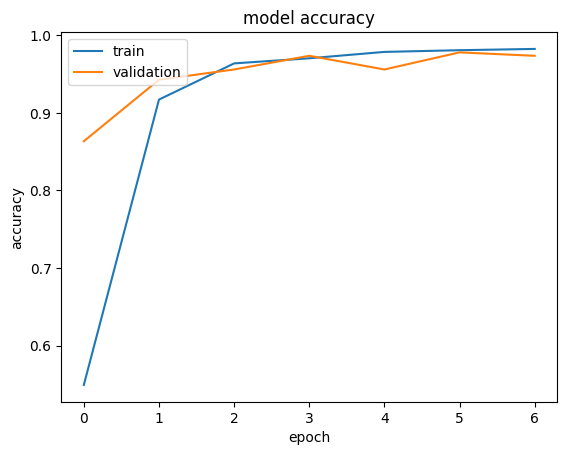

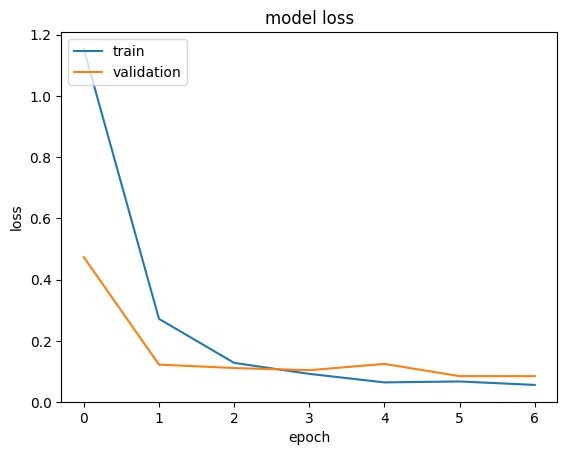

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=7, batch_size=50)

print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Test

In [0]:
loss, acc = model.evaluate(x_test,y_test)
print("Test set accuracy: ",acc)
print("Test set loss: ", loss)

228/228 [==============================] - 4s 18ms/step
Test set accuracy:  0.9649122807017544
Test set loss:  0.1406455621926988


### Save Model

In [0]:
# Saves the model in a hdf5 file
model.save('/content/drive/My Drive/Colab Notebooks/Model_7epoch.h5')

# Application

In [0]:
# Load model from saved hdf5 file
model = load_model('/content/drive/My Drive/Colab Notebooks/Model_7epoch.h5',custom_objects={'AttentionLayer': AttentionLayer})

articleDB = pd.DataFrame(columns = ['Title','Summary','Text','Category','Tags'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
articleDB.head()

,Title,Summary,Text,Category,Tags


### Input

In [0]:
# Input url of interested article
#article_url = 'https://www.bbc.com/news/business-47068401'
#article_url = 'https://www.bbc.com/news/technology-47071334'
#article_url = 'https://www.bbc.com/news/entertainment-arts-39083228'
article_url = 'https://www.bbc.com/news/newsbeat-47069144'
page = requests.get(article_url) 
soup = BeautifulSoup(page.content,'lxml')

# Get title
articlebody = soup.find("div", {"class": "story-body"})
article_title = soup.find("h1",{"class":"story-body__h1"}).text
print(article_title)

# Get news article
story = soup.find("div", {"class": "story-body__inner"}).findAll('p')
article = []
for p in story:
    p_class = p.get('class')
    if p_class:
        no_twite = [x for x in p_class if "twite" not in x]
        no_intro = [x for x in p_class if "story-body__introduction" not in x]
        if no_twite and no_intro:
            article.append(p.text)
    else:
        article.append(p.text)
article = ' '.join(article)
print(article)

# Clean article with pre described rules
article_cleaned,idx_list = cleanString(article,stopWords)
input_array = wordToSeq(article_cleaned,word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)

Women in film: 'We're living in the dark ages when it comes to representation'
That's the norm when it comes to Hollywood's biggest films, according to US campaign group, Time's Up. They've shared figures which reveal only 4% of the biggest earning films from the past decade have been directed by women. And now they're calling on Hollywood studios and stars to change that. Time's Up has launched the #4percentchallenge, and stars Tessa Thompson, Brie Larson and Bryce Dallas Howard are among the names to lend their support. Time's Up's campaign to draw attention to this inequality has been welcomed by rising female film talent here in the UK. "Four percent is a pretty depressing figure, but things like this challenge are absolutely necessary," British director Georgia Parris told Radio 1 Newsbeat. She premiered her first full-length film, Mari, at the BFI Film Festival. "It's that age-old problem that women are hired on experience and men are hired on potential. "So if we're not being gi

NameError: ignored

### Sentence Attention Word

In [0]:
sent_att_weights = Model(inputs=sent_input,outputs=sent_coeffs)
output_array = sent_att_weights.predict(np.resize(input_array,(1,MAX_SENTENCE_NUM,MAX_WORD_NUM)))

# Get n sentences with most attention in document
n_sentences = 15
sent_index = output_array.flatten().argsort()[-n_sentences:]
sent_index = np.sort(sent_index)
sent_index = sent_index.tolist()

# Create summary using n sentences
sent_list = tokenize.sent_tokenize(article)
summary = [sent_list[i] for i in sent_index]

### Word Attention Model

In [0]:
def wordAttentionWeights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)

    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait

# Summary as input for word attention
summary_cleaned, summary_idx = cleanString(' '.join(summary),stopWords)
word_input_array = wordToSeq(summary_cleaned,word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)

# Create model from word input to output of dense layer right before the attention layer
hidden_word_encoding_out = Model(inputs=wordEncoder.input, outputs=wordEncoder.get_layer('word_dense').output)
# Load weights from trained attention layer
word_context = wordEncoder.get_layer('word_attention').get_weights()
# Compute output of dense layer
hidden_word_encodings = hidden_word_encoding_out.predict(word_input_array)
# Compute context vector using output of dense layer
ait = wordAttentionWeights(hidden_word_encodings,word_context)

In [0]:
# Get n words with most attention in document
n_words = 15

flattenlist = []
words_unpadded = []
for idx,sent in enumerate(tokenize.sent_tokenize(summary_cleaned)):
    if(idx>=MAX_SENTENCE_NUM):
        break
    attword_list = tokenize.word_tokenize(sent.rstrip('.'))
    ait_short = (1000*ait[idx][:len(attword_list)]).tolist()
    words_unpadded.extend(ait_short)
    flattenlist.extend(attword_list)

    
words_unpadded = np.array(words_unpadded)
sorted_wordlist = [flattenlist[i] for i in words_unpadded.argsort()]

mostAtt_words = []
i = 0
for word in reversed(sorted_wordlist):
    if word not in mostAtt_words:
        mostAtt_words.append(word)
        i += 1
    if(i>=n_words):
        break

### Output

In [0]:
#Category
res = model.predict(np.expand_dims(input_array,axis=0)).flatten()
cat = categoryToCode[np.argmax(res.flatten())]

# Display information
display(HTML('<h2>'+article_title.rstrip('.')+'</h2>'))
print(cat, mostAtt_words)

display(HTML('<h5>Summary of article:</h5>'))
display(' '.join(summary))

display(HTML('<h5>Full text:</h5>'))
display(article)

entertainment ['film', 'mari', 'bfi', 'premiered', 'movie', 'website', 'see', 'actor', 'studio', 'directed', 'future', 'girl', 'first', 'hollywood', 'star']


'They\'ve shared figures which reveal only 4% of the biggest earning films from the past decade have been directed by women. And now they\'re calling on Hollywood studios and stars to change that. Time\'s Up\'s campaign to draw attention to this inequality has been welcomed by rising female film talent here in the UK. She premiered her first full-length film, Mari, at the BFI Film Festival. Movements like the #4percentchallenge are inspiring confidence in future movie-makers, such as film student and aspiring director Beatrice Sutcliffe. "We\'re living in the dark ages when it comes to representation in film and the films that are being made," Beatrice tells Newsbeat. Alongside a more "truthful depiction of women," Beatrice says she wants to see an end to male-directed films using women\'s bodies as a punchline. "I want to see a film where a woman actually has her period and it doesn\'t stop her," she says. At the end of the day, when a woman is having a period in a film, it tends to b

'That\'s the norm when it comes to Hollywood\'s biggest films, according to US campaign group, Time\'s Up. They\'ve shared figures which reveal only 4% of the biggest earning films from the past decade have been directed by women. And now they\'re calling on Hollywood studios and stars to change that. Time\'s Up has launched the #4percentchallenge, and stars Tessa Thompson, Brie Larson and Bryce Dallas Howard are among the names to lend their support. Time\'s Up\'s campaign to draw attention to this inequality has been welcomed by rising female film talent here in the UK. "Four percent is a pretty depressing figure, but things like this challenge are absolutely necessary," British director Georgia Parris told Radio 1 Newsbeat. She premiered her first full-length film, Mari, at the BFI Film Festival. "It\'s that age-old problem that women are hired on experience and men are hired on potential. "So if we\'re not being given the opportunities to gain that experience then how is the proble

In [0]:
print(res)
print(categoryToCode)

[8.9238511e-06 9.9986887e-01 4.3591226e-05 4.2577944e-05 3.5963330e-05]
{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}


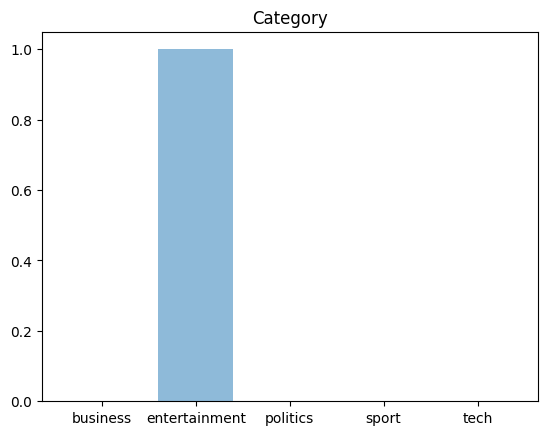

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = [v for k, v in categoryToCode.items()]
y_pos = np.arange(len(objects))
performance = res
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Category')
 
plt.show()

In [0]:
x_train.shape[0]

1822

In [0]:
for position in x_train.shape[0]:
  x_train[position]

(1, 40, 50)

In [0]:
from sklearn.manifold import TSNE
import pandas as pd

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne_tfidf = tsne_model.fit_transform(x_train[1])
print(tsne_tfidf.shape)
tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
tsne_tfidf_df.columns = ['x', 'y']

[t-SNE] Computing 39 nearest neighbors...
[t-SNE] Indexed 40 samples in 0.000s...
[t-SNE] Computed neighbors for 40 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 40 / 40
[t-SNE] Mean sigma: 1.135924
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.552994
[t-SNE] KL divergence after 500 iterations: 0.583712
(40, 2)


# Essai - My text

In [0]:
# Load model from saved hdf5 file
model = load_model('/content/drive/My Drive/Colab Notebooks/Model_7epoch.h5',custom_objects={'AttentionLayer': AttentionLayer})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
adrien_text = '''Share prices for the British drugmaker Indivior plunged today on the London Stock Exchange. The drop came on news that the U.S. Justice Department indicted the company on fraud and conspiracy charges. Indivior makes the drug Suboxone, widely used to treat people suffering from opioid addiction. Federal prosecutors now claim the company falsely marketed Suboxone as safer and less prone to abuse than cheaper generic drugs. North Country Public Radio's Brian Mann reports.

BRIAN MANN, BYLINE: The 28-count indictment filed in a Virginia court claims Indivior executives lied when they claimed dissolvable Suboxone films placed under the tongue would be safer, harder to misuse than generic tablets that were about to come on the market. Government investigators say, in some cases, Indivior's version of the drug was more risky. The indictment claims taxpayer-funded programs like Medicare and Medicaid were cheated out of billions of dollars. Justice Department officials declined NPR's request for an interview. Robert Bird is a professor of business law at the University of Connecticut who follows opioid cases closely. He says this criminal indictment sends a powerful signal to a drug industry already snared in the opioid addiction crisis.

ROBERT BIRD: Not only the companies that are being indicted but also other organizations and competitors who will look at these prosecutions and say, I don't want this to happen to me.

MANN: Indivior executives also declined to be interviewed by NPR. But company spokesperson Jennifer Ginther read from a prepared statement, denying any wrongdoing and describing the federal indictment as misguided.

JENNIFER GINTHER: Indivior's top priority has always been the treatment of patients struggling with opioid addiction. No other company has done more to fight the opioid crisis.'''

In [0]:
# Clean article with pre described rules
stopWords = set(stopwords.words('english'))
article_cleaned_adrien, idx_list = cleanString(adrien_text,stopWords)
input_array = wordToSeq(article_cleaned_adrien,word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)

In [0]:
sent_att_weights = Model(inputs=sent_input,outputs=sent_coeffs)
output_array = sent_att_weights.predict(np.resize(input_array,(1,MAX_SENTENCE_NUM,MAX_WORD_NUM)))

# Get n sentences with most attention in document
n_sentences = 15
sent_index = output_array.flatten().argsort()[-n_sentences:]
sent_index = np.sort(sent_index)
sent_index = sent_index.tolist()

# Create summary using n sentences
sent_list = tokenize.sent_tokenize(adrien_text)
summary = [sent_list[i] for i in sent_index]

In [0]:
summary

['Share prices for the British drugmaker Indivior plunged today on the London Stock Exchange.',
 'The drop came on news that the U.S. Justice Department indicted the company on fraud and conspiracy charges.',
 'Indivior makes the drug Suboxone, widely used to treat people suffering from opioid addiction.',
 'Federal prosecutors now claim the company falsely marketed Suboxone as safer and less prone to abuse than cheaper generic drugs.',
 "North Country Public Radio's Brian Mann reports.",
 'BRIAN MANN, BYLINE: The 28-count indictment filed in a Virginia court claims Indivior executives lied when they claimed dissolvable Suboxone films placed under the tongue would be safer, harder to misuse than generic tablets that were about to come on the market.',
 "Government investigators say, in some cases, Indivior's version of the drug was more risky.",
 'The indictment claims taxpayer-funded programs like Medicare and Medicaid were cheated out of billions of dollars.',
 "Justice Department of

In [0]:
def wordAttentionWeights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)

    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait

# Summary as input for word attention
summary_cleaned, summary_idx = cleanString(' '.join(summary),stopWords)
word_input_array = wordToSeq(summary_cleaned,word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)

# Create model from word input to output of dense layer right before the attention layer
hidden_word_encoding_out = Model(inputs=wordEncoder.input, outputs=wordEncoder.get_layer('word_dense').output)
# Load weights from trained attention layer
word_context = wordEncoder.get_layer('word_attention').get_weights()
# Compute output of dense layer
hidden_word_encodings = hidden_word_encoding_out.predict(word_input_array)
# Compute context vector using output of dense layer
ait = wordAttentionWeights(hidden_word_encodings,word_context)

In [0]:
# Get n words with most attention in document
n_words = 1000

flattenlist = []
words_unpadded = []
for idx,sent in enumerate(tokenize.sent_tokenize(summary_cleaned)):
    print(idx)
    print(sent)
    if(idx>=MAX_SENTENCE_NUM):
        break
    attword_list = tokenize.word_tokenize(sent.rstrip('.'))
    print(attword_list)
    ait_short = (1000*ait[idx][:len(attword_list)]).tolist()
    print(ait_short)
    words_unpadded.extend(ait_short)
    flattenlist.extend(attword_list)

    
words_unpadded = np.array(words_unpadded)
sorted_wordlist = [flattenlist[i] for i in words_unpadded.argsort()]

mostAtt_words = []
i = 0
for word in reversed(sorted_wordlist):
    if word not in mostAtt_words:
        mostAtt_words.append(word)
        i += 1
    if(i>=n_words):
        break

0
share price british drugmaker indivior plunged today london stock exchange .
['share', 'price', 'british', 'drugmaker', 'indivior', 'plunged', 'today', 'london', 'stock', 'exchange']
[0.6195275187492371, 0.7179938554763794, 0.5452634692192078, 0.6008207201957703, 0.6205522418022156, 0.5354278087615967, 0.4509541690349579, 0.7289270162582397, 0.5647255182266235, 0.5161217451095581]
1
drop came news justice department indicted company fraud conspiracy charge .
['drop', 'came', 'news', 'justice', 'department', 'indicted', 'company', 'fraud', 'conspiracy', 'charge']
[0.5931758880615234, 0.5210106372833252, 0.4407845437526703, 0.532782793045044, 0.4997051954269409, 0.63340163230896, 0.5803787112236023, 0.5865179896354675, 0.5949891805648804, 0.5462245941162109]
2
indivior make drug suboxone widely used treat people suffering opioid addiction .
['indivior', 'make', 'drug', 'suboxone', 'widely', 'used', 'treat', 'people', 'suffering', 'opioid', 'addiction']
[0.6649157404899597, 0.6490614414

In [0]:
#Category
categoryToCode = {0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

res = model.predict(np.expand_dims(input_array,axis=0)).flatten()
cat = categoryToCode[np.argmax(res.flatten())]

In [0]:
print(cat, mostAtt_words)

sport ['abuse', 'suboxone', 'company', 'billion', 'london', 'cheaper', 'price', 'harder', 'statement', 'film', 'indictment', 'version', 'denying', 'generic', 'describing', 'safer', 'drug', 'placed', 'indivior', 'indicted', 'falsely', 'prosecution', 'wrongdoing', 'government', 'marketed', 'make', 'misuse', 'ginther', 'cheated', 'say', 'federal', 'le', 'share', 'filed', 'signal', 'dollar', 'bird', 'tongue', 'always', 'drugmaker', 'medicaid', 'competitor', 'medicare', 'claim', 'conspiracy', 'look', 'drop', 'fraud', 'top', 'executive', 'priority', 'risky', 'like', 'used', 'stock', 'treatment', 'read', 'court', 'dissolvable', 'mann', 'charge', 'british', 'byline', 'want', 'business', 'connecticut', 'npr', 'tablet', 'prone', 'interview', 'plunged', 'powerful', 'justice', 'industry', 'widely', 'prepared', 'sends', 'come', 'came', 'declined', 'follows', 'criminal', 'crisis', 'exchange', 'lied', 'addiction', 'market', 'misguided', 'would', 'virginia', 'professor', 'opioid', 'department', 'treat